In [10]:
#import libraries
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 

[nltk_data] Downloading package stopwords to C:\Users\Alok
[nltk_data]     Agrawal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Alok
[nltk_data]     Agrawal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ModuleNotFoundError: No module named 'xgboost'

In [9]:
!pip install textblob

In [11]:
!pip install pmdarima

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


#Numerical Analysis

In [12]:
df_prices = pd.read_csv(r'C:\Users\Alok Agrawal\Downloads\CSV.csv')
print(df_prices.head())
print(df_prices.size)

         Date       Open       High    Low      Close  Adj Close  Volume
0  2020-01-02  25.620001  25.620001  25.00  25.270000  24.881821   74300
1  2020-01-03  25.059999  25.510000  25.00  25.430000  25.039360   81800
2  2020-01-06  25.340000  25.730000  25.16  25.690001  25.295368   77600
3  2020-01-07  25.709999  26.040001  25.27  25.320000  24.931049   94400
4  2020-01-08  25.200001  25.320000  25.02  25.280001  24.891665   66000
1771


In [13]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   Open       253 non-null    float64       
 2   High       253 non-null    float64       
 3   Low        253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Adj Close  253 non-null    float64       
 6   Volume     253 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.0 KB


In [14]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

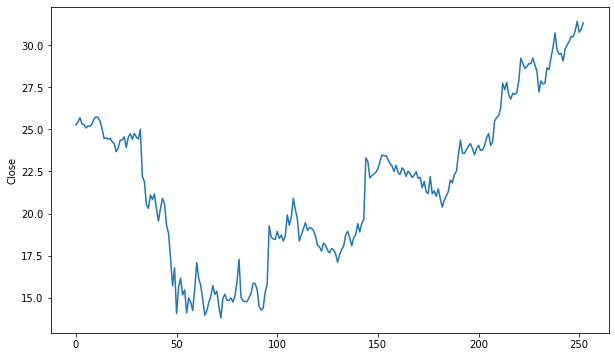

In [15]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

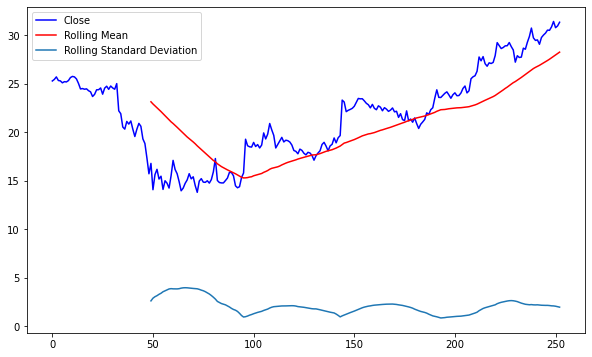

In [16]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

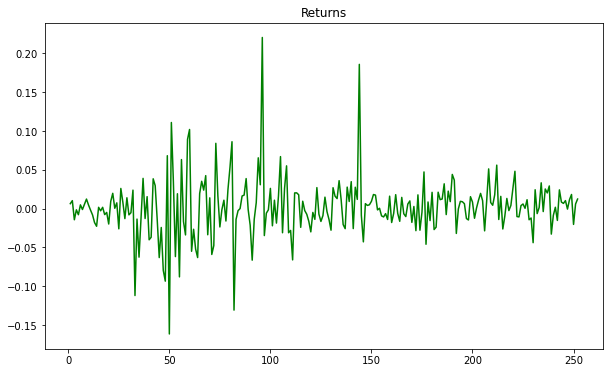

In [17]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [28]:
df_prices.shape

(253, 7)

In [30]:
train = df_prices[:203]
test = df_prices[203:]

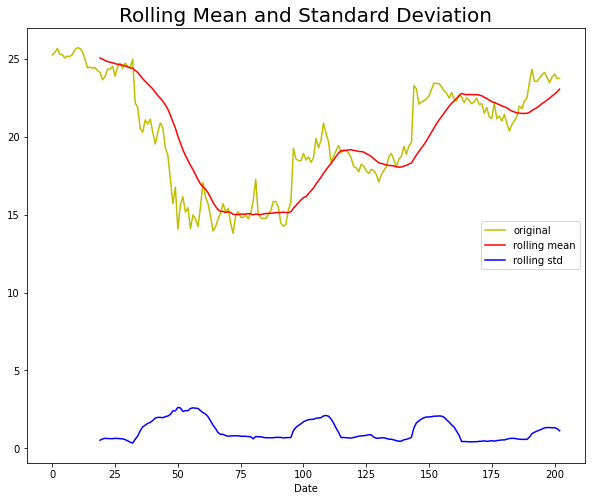

Results of dickey fuller test
ADF Test Statistic : -1.6637300207469554
p-value : 0.4498900237431626
#Lags Used : 0
Number of Observations Used : 202
Weak evidence against null hypothesis, time series is non-stationary 


In [31]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

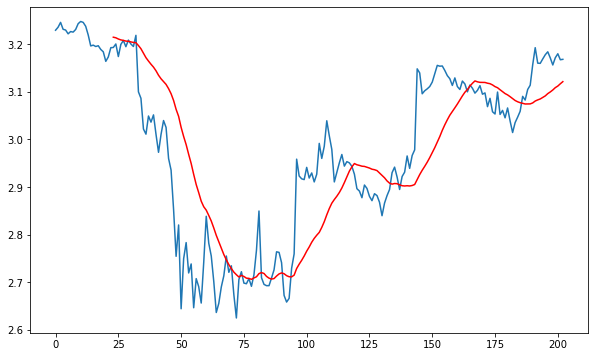

In [32]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

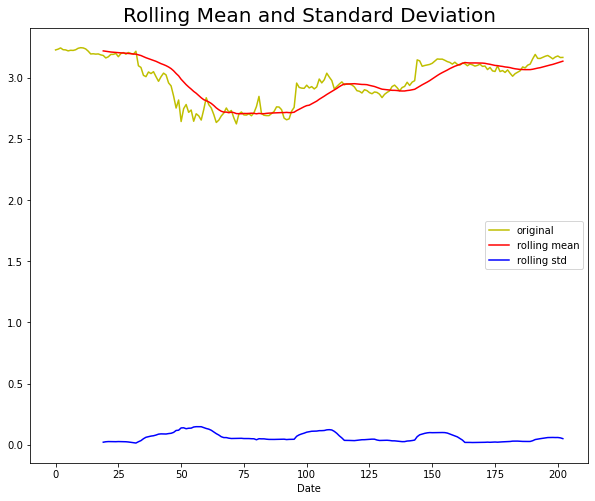

Results of dickey fuller test
ADF Test Statistic : -1.7154966972231525
p-value : 0.4231463178535793
#Lags Used : 0
Number of Observations Used : 202
Weak evidence against null hypothesis, time series is non-stationary 


In [33]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

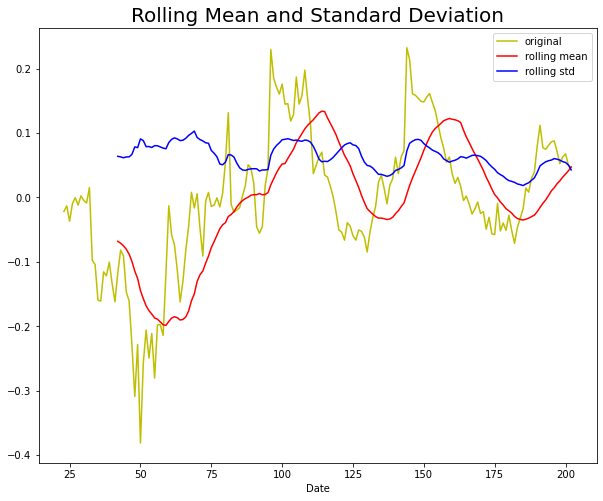

Results of dickey fuller test
ADF Test Statistic : -2.611236262963017
p-value : 0.0906971267389507
#Lags Used : 0
Number of Observations Used : 179
Weak evidence against null hypothesis, time series is non-stationary 


In [34]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [35]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
203,2020-10-21,23.879999,24.059999,23.760000,24.030001,23.943501,34500
204,2020-10-22,24.139999,24.650000,23.950001,24.500000,24.411808,46500
205,2020-10-23,24.559999,25.219999,24.559999,24.750000,24.660908,59500
206,2020-10-26,24.490000,24.490000,23.709999,24.040001,23.953465,48400
207,2020-10-27,24.049999,24.379999,23.750000,24.260000,24.172672,88800


In [37]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-714.219, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-719.990, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-719.885, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-719.876, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-721.979, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-717.885, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.678 seconds


Text(0, 0.5, 'Actual Stock Price')

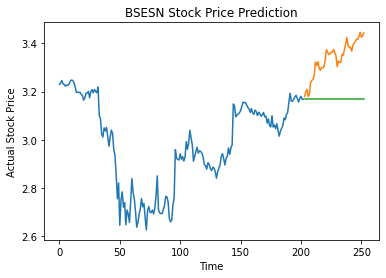

In [38]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [39]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.18402193987360513


#Sentiment Analysis on News Headlines

In [40]:
#read data
df_news = pd.read_csv(r'C:\Users\Alok Agrawal\Downloads\india-news-headlines.csv')
df_news.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [41]:
df_news.describe()

,publish_date
count,3.297172e+06
mean,2.012470e+07
std,4.896213e+04
min,2.001010e+07
25%,2.009101e+07
50%,2.013071e+07
75%,2.016110e+07
max,2.020063e+07


In [45]:

df_news.drop(columns=['headline_category'], inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297171 entries, 1 to 3297171
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   publish_date   int64 
 1   headline_text  object
dtypes: int64(1), object(1)
memory usage: 235.5+ MB


In [47]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['publish_date'],format= '%Y%m%d')
df_news


,publish_date,headline_text,Date
1,20010102,Status quo will not be disturbed at Ayodhya; s...,2001-01-02
2,20010102,Fissures in Hurriyat over Pak visit,2001-01-02
3,20010102,America's unwanted heading for India?,2001-01-02
4,20010102,For bigwigs; it is destination Goa,2001-01-02
5,20010102,Extra buses to clear tourist traffic,2001-01-02
...,...,...,...
3297167,20200630,why tiktok removed 1 65 crore videos in india,2020-06-30
3297168,20200630,apurva asrani calls alia bhatts mother soni ra...,2020-06-30
3297169,20200630,kangana ranaut gets a doll version of herself ...,2020-06-30
3297170,20200630,meezaan jaffrey reminisces his childhood days ...,2020-06-30


In [48]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,publish_date,headline_text,Date,News
0,20010102,Status quo will not be disturbed at Ayodhya; s...,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,20010102,Fissures in Hurriyat over Pak visit,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,20010102,America's unwanted heading for India?,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
3,20010102,For bigwigs; it is destination Goa,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
4,20010102,Extra buses to clear tourist traffic,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
...,...,...,...,...
3154910,20200630,why tiktok removed 1 65 crore videos in india,2020-06-30,Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
3154911,20200630,apurva asrani calls alia bhatts mother soni ra...,2020-06-30,Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
3154912,20200630,kangana ranaut gets a doll version of herself ...,2020-06-30,Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
3154913,20200630,meezaan jaffrey reminisces his childhood days ...,2020-06-30,Detective Byomkesh Bakshy! Edge of Tomorrow Fi...


In [50]:
ps = PorterStemmer()

In [ ]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [ ]:
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

In [ ]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

In [ ]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

In [ ]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

In [ ]:
#Build model
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

In [ ]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))